In [1]:
import pycid
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def draw(maid, node_color=None, node_shape=None, layout=None):
    """
    Helper function for drawing the MAID.

    Note: Copied from PyCID.
    """
    color = node_color if node_color else maid._get_color
    shape = node_shape if node_shape else maid._get_shape
    layout = layout(maid) if layout else nx.kamada_kawai_layout(maid)

    node_size = 600
    arrowsize = 20
    font_size = 8

    nx.draw_networkx_edges(
        maid, pos=layout, node_size=node_size, arrowsize=arrowsize, arrowstyle='->')

    for node in maid.nodes:
        nx.draw_networkx(maid.to_directed().subgraph([node]),
                         pos=layout,
                         node_size=node_size,
                         arrowsize=arrowsize,
                         node_color=color(node),
                         node_shape=shape(node),
                         font_size=font_size)
    plt.show()


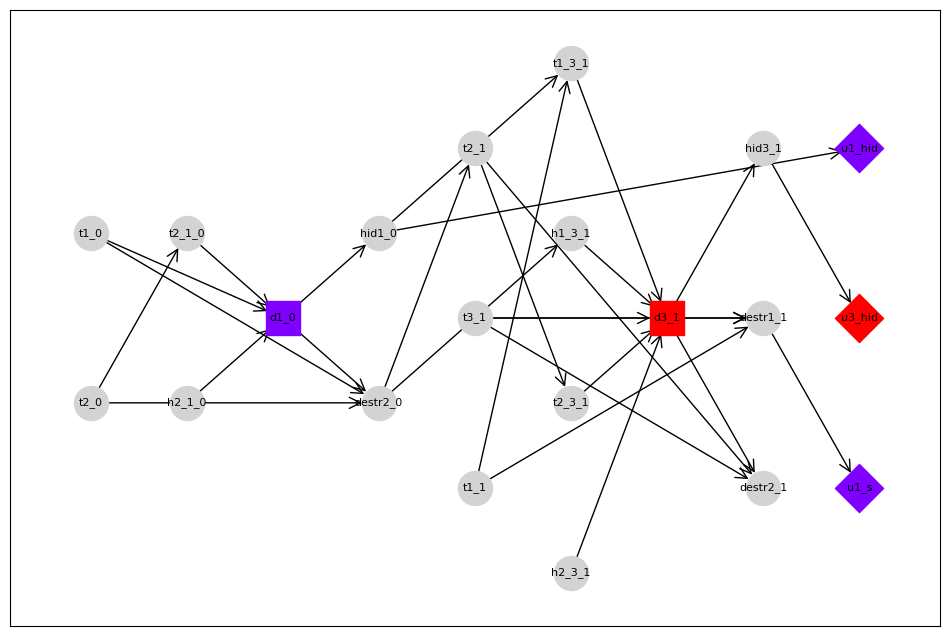

In [3]:
agents = {1, 2, 3}
actors = (1, 3)
# here we assume that capabilities stay constant. In the actual model these
# would be derived from technology levels
capabilities = {1: (2,), 2: (1, 3), 3: (1, 2)}
#tech_levels = {1: (0.1, 0.1), 2: (0.4, 0.5), 3: (1.0, 1.0)}

maid = pycid.MACID([],
                   # define agent decision and utility nodes
                   agent_decisions={actor: [f"d{actor}_{t}"
                                            for t, act in enumerate(actors)
                                            if act == actor]
                                    for actor in set(actors)},
                   agent_utilities={actor: [f"u{actor}_s", f"u{actor}_hid"]
                                    for actor in actors})

for t, actor in enumerate(actors):

    # tech level nodes
    tech_nodes = (f"t{civ}_{t}" for civ in agents)

    # tech level belief nodes for actor
    tech_belief_nodes = (f"t{civ}_{actor}_{t}" for civ in capabilities[actor])

    # hostility belief nodes for actor
    hostility_belief_nodes = (
        f"h{civ}_{actor}_{t}" for civ in capabilities[actor])

    # result nodes for actor
    result_nodes = [
        f"destr{civ}_{t}" for civ in capabilities[actor]] + [f"hid{actor}_{t}"]

    # future
    fut_times = tuple(range(t+1, len(actors)))
    fut_actors = actors[t+1:]

    # add nodes and edges for timestep t and edges to (possible) next timestep
    maid.add_edges_from([
        # actor observes its technology level directly
        (f"t{actor}_{t}", f"d{actor}_{t}"),
        # actor has beliefs about technology levels of civs it observes
        *((f"t{civ}_{t}", f"t{civ}_{actor}_{t}")
          for civ in capabilities[actor]),
        *((f"t{civ}_{actor}_{t}", f"d{actor}_{t}")
          for civ in capabilities[actor]),
        # actor has beliefs about the hostilities of the civs it observes
        *((f"h{civ}_{actor}_{t}", f"d{actor}_{t}")
          for civ in capabilities[actor]),
        # actor can control whether it hides or not
        (f"d{actor}_{t}", f"hid{actor}_{t}"),
        (f"hid{actor}_{t}", f"u{actor}_hid"),
        *((f"hid{actor}_{t}", f"t{actor}_{f_actor}_{f_t}")
          for f_t, f_actor in zip(fut_times, fut_actors) if f_actor != actor),
        # actor can attempt to destroy the civs it observes
        *((f"d{actor}_{t}", f"destr{civ}_{t}") for civ in capabilities[actor]),
        # the success influenced by the actual tehcnology levels of the pair
        *((f"t{actor}_{t}", f"destr{civ}_{t}") for civ in capabilities[actor]),
        *((f"t{civ}_{t}", f"destr{civ}_{t}") for civ in capabilities[actor]),
        # add connections to survival utility nodes
        *((f"destr{civ}_{t}", f"u{civ}_s")
          for civ in capabilities[actor]
          if civ in actors),
        # destroying a civilisation has an effect on its tech level
        *((f"destr{civ}_{t}", f"t{civ}_{f_t}")
          for civ in capabilities[actor]
          for f_t in fut_times),
        # if attack is unsuccessful, the target's hostility perception
        # of the attacker is updated
        *((f"destr{f_actor}_{t}", f"h{actor}_{f_actor}_{f_t}")
          for f_t, f_actor in zip(fut_times, fut_actors)
          if f_actor in capabilities[actor]),
        # if an attack is successful, everyone who can observe it
        # updates their hostility perceptions
        *((f"destr{civ}_{t}", f"h{nbr}_{f_actor}_{f_t}")
          for civ in capabilities[actor]
          for f_t, f_actor in zip(fut_times, fut_actors)
          for nbr in capabilities[f_actor] if civ != f_actor and civ != nbr)
    ])

    # set subsets of nodes to display them neatly.
    # the numbers after the timestep affect the ordering of node sets within
    # a timestep
    nx.set_node_attributes(
        maid, {n: f"{t}0_tech" for n in tech_nodes}, name="subset")
    nx.set_node_attributes(
        maid, {n: f"{t}1_belief" for n in tech_belief_nodes}, name="subset")
    nx.set_node_attributes(
        maid, {n: f"{t}1_belief" for n in hostility_belief_nodes}, name="subset")
    nx.set_node_attributes(
        maid, {f"d{actor}_{t}": f"{t}2_decision"}, name="subset")
    nx.set_node_attributes(
        maid, {n: f"{t}3_result" for n in result_nodes}, name="subset")

# set the subset of utility nodes
utility_nodes = [f"u{actor}_{util}"
                 for actor in actors
                 for util in ("s", "hid")]
nx.set_node_attributes(
    maid, {n: "utility" for n in utility_nodes}, name="subset")

plt.figure(figsize=(12, 8))
draw(maid, layout=nx.multipartite_layout)


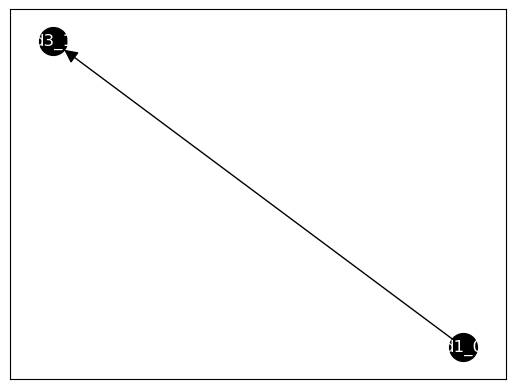

In [4]:
pycid.RelevanceGraph(maid).draw()